In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
from sklearn import metrics as mt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from matplotlib.pyplot import figure

In [2]:
path = os.getcwd()
#path = "C:/Users/zzaik/OneDrive/SMU work/quantifying the world/case study/case study 4"
arff_files = glob.glob(os.path.join(path, 'data', '*.arff'))
allfiles = [i for i in arff_files]
df = pd.concat([pd.DataFrame(arff.loadarff(f)[0]) for f in allfiles], axis=0)
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [4]:
df.shape

(43405, 65)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43405 entries, 0 to 7026
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   43397 non-null  float64
 1   Attr2   43397 non-null  float64
 2   Attr3   43397 non-null  float64
 3   Attr4   43271 non-null  float64
 4   Attr5   43316 non-null  float64
 5   Attr6   43397 non-null  float64
 6   Attr7   43397 non-null  float64
 7   Attr8   43311 non-null  float64
 8   Attr9   43396 non-null  float64
 9   Attr10  43397 non-null  float64
 10  Attr11  43361 non-null  float64
 11  Attr12  43271 non-null  float64
 12  Attr13  43278 non-null  float64
 13  Attr14  43397 non-null  float64
 14  Attr15  43369 non-null  float64
 15  Attr16  43310 non-null  float64
 16  Attr17  43311 non-null  float64
 17  Attr18  43397 non-null  float64
 18  Attr19  43277 non-null  float64
 19  Attr20  43278 non-null  float64
 20  Attr21  37551 non-null  float64
 21  Attr22  43397 non-null  float64
 22 

In [3]:
df.isna().mean()

Attr1     0.000184
Attr2     0.000184
Attr3     0.000184
Attr4     0.003087
Attr5     0.002050
            ...   
Attr61    0.002350
Attr62    0.002926
Attr63    0.003087
Attr64    0.018708
class     0.000000
Length: 65, dtype: float64

In [4]:
# MISSING DATA
missing_df = pd.DataFrame(df.isna().mean()).reset_index()

missing_df.rename(columns={ missing_df.columns[1]: "Percent_Missing" },inplace=True)
missing_df.rename(columns={ missing_df.columns[0]: "Feature" },inplace=True)

missing_df = missing_df.sort_values('Percent_Missing', ascending=False)

In [5]:
missing_summary = missing_df[(missing_df['Percent_Missing'] > 0)]#.head(15)
missing_summary

,Feature,Percent_Missing
36,Attr37,0.437369
20,Attr21,0.134869
26,Attr27,0.063679
59,Attr60,0.049580
44,Attr45,0.049464
...,...,...
13,Attr14,0.000184
9,Attr10,0.000184
56,Attr57,0.000161
58,Attr59,0.000161


In [6]:
df['class'] = [0 if x in b'0' else 1 for x in df['class']]

In [7]:
bankruptcy_perc_missing = []
bankruptcy_perc_non_missing = []
all_bankruptcy_perc = []
perc_of_total = []
feature_list = missing_summary['Feature'].tolist()
feature_avg_bankruptcy = []
feature_avg_non_bankruptcy = []
feature_avg_all = []

for i in range(len(missing_summary)):
    null_df = df[df[feature_list[i]].isnull()]
    notnull_df = df[df[feature_list[i]].notnull()]
    bankruptcy_perc_missing.append(len(null_df[null_df['class'].eq(1)])/len(null_df))
    bankruptcy_perc_non_missing.append(len(notnull_df[notnull_df['class'].eq(1)])/len(notnull_df))   
    all_bankruptcy_perc.append(len(df[df['class'].eq(1)])/len(df))
    perc_of_total.append(len(null_df[null_df['class'].eq(1)])/len(df[df['class'].eq(1)]))
    feature_avg_bankruptcy.append(notnull_df[notnull_df['class'].eq(1)][feature_list[i]].mean())
    feature_avg_non_bankruptcy.append(notnull_df[notnull_df['class'].eq(0)][feature_list[i]].mean())
    feature_avg_all.append(notnull_df[feature_list[i]].mean())

In [8]:
missing_summary['bankruptcy_perc_missing_data']= bankruptcy_perc_missing
missing_summary['bankruptcy_perc_Non_missing_data']= bankruptcy_perc_non_missing
missing_summary['bankruptcy_perc_all_data']= all_bankruptcy_perc
missing_summary['missing_as_per_of_total'] = perc_of_total
missing_summary['feature_avg_bankruptcy'] = feature_avg_bankruptcy
missing_summary['feature_avg_non_bankruptcy'] = feature_avg_non_bankruptcy
missing_summary['feature_avg_all'] = feature_avg_all

missing_summary.head(n=15)

,Feature,Percent_Missing,bankruptcy_perc_missing_data,bankruptcy_perc_Non_missing_data,bankruptcy_perc_all_data,missing_as_per_of_total,feature_avg_bankruptcy,feature_avg_non_bankruptcy,feature_avg_all
36,Attr37,0.437369,0.051464,0.045616,0.048174,0.467241,63.985657,107.049797,105.085363
20,Attr21,0.134869,0.105056,0.039307,0.048174,0.294118,1.355427,3.988494,3.884997
26,Attr27,0.063679,0.258683,0.033857,0.048174,0.341942,31.914293,1145.602955,1107.896314
59,Attr60,0.049580,0.081784,0.046421,0.048174,0.084170,135.458097,463.304748,448.085823
44,Attr45,0.049464,0.081975,0.046415,0.048174,0.084170,4.330191,15.335846,14.825016
23,Attr24,0.021242,0.001085,0.049196,0.048174,0.000478,-0.268151,0.297857,0.270012
63,Attr64,0.018708,0.098522,0.047214,0.048174,0.038259,108.304263,71.028649,72.788592
52,Attr53,0.018708,0.098522,0.047214,0.048174,0.038259,49.818246,22.481959,23.772623
27,Attr28,0.018708,0.098522,0.047214,0.048174,0.038259,3.115678,6.146296,6.003208
53,Attr54,0.018708,0.098522,0.047214,0.048174,0.038259,50.988679,23.349746,24.654700


In [9]:
for i in range(len(feature_list)):
    df.loc[(df[feature_list[i]].isnull())  & (df['class'] == 1),feature_list[i]] = missing_summary[missing_summary['Feature'] == feature_list[i]]['feature_avg_bankruptcy'].values[0]
    df.loc[(df[feature_list[i]].isnull())  & (df['class'] == 0),feature_list[i]] = missing_summary[missing_summary['Feature'] == feature_list[i]]['feature_avg_non_bankruptcy'].values[0]
    
    
    

In [10]:
 pd.DataFrame(df.isna().mean()).reset_index()

,index,0
0,Attr1,0.0
1,Attr2,0.0
2,Attr3,0.0
3,Attr4,0.0
4,Attr5,0.0
...,...,...
60,Attr61,0.0
61,Attr62,0.0
62,Attr63,0.0
63,Attr64,0.0


In [9]:
#Impute the missing value with their mean
#df = df.fillna(df.mean())

In [11]:
df['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

In [11]:
#df['class'] = [0 if x in b'0' else 1 for x in df['class']]

In [12]:
df['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

In [13]:
X = df.drop(['class'], axis=1).copy()
y= df['class'].copy()

In [11]:
scaler = StandardScaler()
X_scl = scaler.fit_transform(X)
X_scl = pd.DataFrame(data=X_scl, columns=X.columns)

### Random Forest

In [12]:

tuned_parameters = {'n_estimators': [300, 500], 'criterion':['entropy'], 'max_depth':[None], 'min_samples_leaf':[1,5],
                   'max_features':[None, 'Auto'], 'random_state':[1], 'class_weight':['balanced', 'balanced_subsample'],
                   'min_samples_split':[2,4,6]}
scores = ['precision', 'recall', 'accuracy']
rf = RandomForestClassifier()

In [13]:
%%time
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = RandomizedSearchCV(rf, tuned_parameters, cv=5, scoring=score, n_jobs=6, n_iter=20)
    clf.fit(X_scl, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'random_state': 1, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}

Grid scores on development set:

nan (+/-nan) for {'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'Auto', 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
nan (+/-nan) for {'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'Auto', 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.828 (+/-0.324) for {'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.829 (+/-0.328) for {'random_state': 1, 'n_estimators': 500, 'min_samples_

Best parameters set found on development set:

{'random_state': 1, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}

Grid scores on development set:

0.971 (+/-0.008) for {'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
nan (+/-nan) for {'random_state': 1, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'Auto', 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.971 (+/-0.008) for {'random_state': 1, 'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}
nan (+/-nan) for {'random_state': 1, 'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'Au

#### Precision
0.880 (+/-0.229) for {'random_state': 1, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}

#### Recall
0.518 (+/-0.058) for {'random_state': 1, 'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}

#### Accuracy
0.971 (+/-0.008) for {'random_state': 1, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=1, stratify=y, test_size=.2)

In [16]:
#Use best recall hyper-parameter
RF_clf = RandomForestClassifier(max_features= None, bootstrap=True, random_state=1, class_weight='balanced',
    n_estimators= 300, criterion='entropy', min_samples_split=6, min_samples_leaf= 5).fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8263
           1       0.91      0.52      0.67       418

    accuracy                           0.97      8681
   macro avg       0.94      0.76      0.83      8681
weighted avg       0.97      0.97      0.97      8681



Confusion Matrix: 
 [[8242   21]
 [ 199  219]]


Accuracy: 
 0.9746572975463657


In [18]:
recall = mt.recall_score(y_test, RF_clf.predict(X_test))
print("recall\n",recall)

recall
 0.5239234449760766


In [19]:
precision = mt.precision_score(y_test, RF_clf.predict(X_test))
print("precision\n",precision)

precision
 0.9125


#### Don't use below results

In [39]:
#Try the rest of the hpyer-parameters from best accuracy
RF_clf = RandomForestClassifier(max_features= None, bootstrap=True, random_state=1, class_weight='balanced',
                            n_estimators= 300, criterion='entropy', min_samples_split=4, min_samples_leaf= 1).fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8263
           1       0.93      0.47      0.62       418

    accuracy                           0.97      8681
   macro avg       0.95      0.73      0.80      8681
weighted avg       0.97      0.97      0.97      8681



Confusion Matrix: 
 [[8248   15]
 [ 222  196]]


Accuracy: 
 0.9726989978113121


In [41]:
recall = mt.recall_score(y_test, RF_clf.predict(X_test))
print("recall\n",recall)

recall
 0.4688995215311005


In [42]:
precision = mt.precision_score(y_test, RF_clf.predict(X_test))
print("precision\n",precision)

precision
 0.9289099526066351


In [43]:
#Try the rest of the hyper-parameters from best precision
RF_clf = RandomForestClassifier(max_features= None, bootstrap=True, random_state=1, class_weight='balanced_subsample',
                            n_estimators= 300, criterion='entropy', min_samples_split=2, min_samples_leaf= 1).fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8263
           1       0.93      0.47      0.62       418

    accuracy                           0.97      8681
   macro avg       0.95      0.73      0.80      8681
weighted avg       0.97      0.97      0.97      8681



Confusion Matrix: 
 [[8249   14]
 [ 223  195]]


Accuracy: 
 0.9726989978113121


In [45]:
recall = mt.recall_score(y_test, RF_clf.predict(X_test))
print("recall\n",recall)

recall
 0.4665071770334928


In [46]:
precision = mt.precision_score(y_test, RF_clf.predict(X_test))
print("precision\n",precision)

precision
 0.9330143540669856


### XGBoost

In [25]:
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [26]:
#scale_pos_weight = sum(negative instances) / sum(positive instances)
scale_pos_weight = (len(y)-sum(y))/sum(y)
print(scale_pos_weight)

19.758010521281683


In [27]:
#Tune XGBoost
tuned_xgb_parameters = {'n_estimators': [300, 500], 'learning_rate':[1,.1,.01], 'colsample_bytree': [.4,.5,.6,1], 
                        'reg_alpha': [100,50,10,1,.1,.01,.001], 'max_depth':[4,6,9]}

In [28]:
%%time
optimal = RandomizedSearchCV(
   estimator=xgboost.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='aucpr',
                          subsample=0.8,
                          scale_pos_weight=scale_pos_weight,
                          random_state=1,
                          use_label_encoder=False),
     param_distributions=tuned_xgb_parameters,
     scoring='roc_auc', 
     verbose=1,
     n_jobs =6,
     cv = cv, n_iter=20)

optimal.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)], verbose=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0]	validation_0-aucpr:0.15000
[1]	validation_0-aucpr:0.44177
[2]	validation_0-aucpr:0.39658
[3]	validation_0-aucpr:0.47700
[4]	validation_0-aucpr:0.52275
[5]	validation_0-aucpr:0.51623
[6]	validation_0-aucpr:0.55372
[7]	validation_0-aucpr:0.54399
[8]	validation_0-aucpr:0.55735
[9]	validation_0-aucpr:0.58532
[10]	validation_0-aucpr:0.61407
[11]	validation_0-aucpr:0.62158
[12]	validation_0-aucpr:0.61302
[13]	validation_0-aucpr:0.61833
[14]	validation_0-aucpr:0.62955
[15]	validation_0-aucpr:0.64142
[16]	validation_0-aucpr:0.64604
[17]	validation_0-aucpr:0.65572
[18]	validation_0-aucpr:0.66284
[19]	validation_0-aucpr:0.66989
[20]	validation_0-aucpr:0.67646
[21]	validation_0-aucpr:0.67686
[22]	validation_0-aucpr:0.68043
[23]	validation_0-aucpr:0.68922
[24]	validation_0-aucpr:0.69528
[25]	validation_0-aucpr:0.69724
[26]	validation_0-aucpr:0.70035
[27]	validation_0-aucpr:0.70158
[28]	validation_0-aucpr:0.70432
[29]	validation_0-au

[250]	validation_0-aucpr:0.79965
[251]	validation_0-aucpr:0.79995
[252]	validation_0-aucpr:0.80004
[253]	validation_0-aucpr:0.80031
[254]	validation_0-aucpr:0.80043
[255]	validation_0-aucpr:0.80064
[256]	validation_0-aucpr:0.80060
[257]	validation_0-aucpr:0.80081
[258]	validation_0-aucpr:0.80087
[259]	validation_0-aucpr:0.80086
[260]	validation_0-aucpr:0.80129
[261]	validation_0-aucpr:0.80170
[262]	validation_0-aucpr:0.80151
[263]	validation_0-aucpr:0.80190
[264]	validation_0-aucpr:0.80163
[265]	validation_0-aucpr:0.80163
[266]	validation_0-aucpr:0.80169
[267]	validation_0-aucpr:0.80172
[268]	validation_0-aucpr:0.80163
[269]	validation_0-aucpr:0.80134
[270]	validation_0-aucpr:0.80134
[271]	validation_0-aucpr:0.80117
[272]	validation_0-aucpr:0.80128
[273]	validation_0-aucpr:0.80116
Wall time: 16min 49s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='aucpr', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None...
                                           scale_pos_weight=19.758010521281683,
                                           subsample=0.8, tree_method=None,
                                           use_label_encoder=False,
                                           v

In [29]:
print(optimal.best_params_)

{'reg_alpha': 0.01, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [30]:
#Why use aucpr as evaluation metirc
#https://datascience.stackexchange.com/questions/9003/when-do-i-have-to-use-aucpr-instead-of-auroc-and-vice-versa
xgb_clf = xgboost.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='aucpr',
                          subsample=0.8,
                          scale_pos_weight=scale_pos_weight,
                          random_state=1,
                          use_label_encoder=False,
                          reg_alpha=.01,
                          n_estimators=500,
                          max_depth=9,
                          learning_rate=.1,
                          colsample_bytree=.5)


xgb_clf.fit(X_train, y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_train, y_train),(X_test, y_test)])

y_xgb = xgb_clf.predict(X_test)

[0]	validation_0-aucpr:0.29687	validation_1-aucpr:0.15000
[1]	validation_0-aucpr:0.68062	validation_1-aucpr:0.44177
[2]	validation_0-aucpr:0.67142	validation_1-aucpr:0.39658
[3]	validation_0-aucpr:0.74748	validation_1-aucpr:0.47700
[4]	validation_0-aucpr:0.78898	validation_1-aucpr:0.52275
[5]	validation_0-aucpr:0.80076	validation_1-aucpr:0.51623
[6]	validation_0-aucpr:0.84022	validation_1-aucpr:0.55372
[7]	validation_0-aucpr:0.83975	validation_1-aucpr:0.54399
[8]	validation_0-aucpr:0.85265	validation_1-aucpr:0.55735
[9]	validation_0-aucpr:0.87432	validation_1-aucpr:0.58532
[10]	validation_0-aucpr:0.88805	validation_1-aucpr:0.61407
[11]	validation_0-aucpr:0.89614	validation_1-aucpr:0.62158
[12]	validation_0-aucpr:0.90048	validation_1-aucpr:0.61302
[13]	validation_0-aucpr:0.91229	validation_1-aucpr:0.61833
[14]	validation_0-aucpr:0.92054	validation_1-aucpr:0.62955
[15]	validation_0-aucpr:0.92775	validation_1-aucpr:0.64142
[16]	validation_0-aucpr:0.93098	validation_1-aucpr:0.64604
[17]	va

[139]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78080
[140]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78068
[141]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78073
[142]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78017
[143]	validation_0-aucpr:1.00000	validation_1-aucpr:0.77968
[144]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78155
[145]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78136
[146]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78086
[147]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78207
[148]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78211
[149]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78256
[150]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78303
[151]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78310
[152]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78395
[153]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78414
[154]	validation_0-aucpr:1.00000	validation_1-aucpr:0.78434
[155]	validation_0-aucpr:1.00000	validat

In [31]:
print(classification_report(y_test, y_xgb))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_xgb))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_xgb))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8263
           1       0.86      0.61      0.72       418

    accuracy                           0.98      8681
   macro avg       0.92      0.80      0.85      8681
weighted avg       0.97      0.98      0.97      8681



Confusion Matrix: 
 [[8220   43]
 [ 161  257]]


Accuracy: 
 0.9765004031793573


In [34]:
recall = mt.recall_score(y_test, xgb_clf.predict(X_test))
print("recall\n",recall)

recall
 0.6148325358851675


In [35]:
precision = mt.precision_score(y_test, xgb_clf.predict(X_test))
print("precision\n",precision)

precision
 0.8566666666666667


In [36]:
evaluation_results = xgb_clf.evals_result()
train_auc_tree = evaluation_results['validation_0']['aucpr']
test_auc_tree = evaluation_results['validation_1']['aucpr']

In [37]:
#Async video 8.5
evaluation_output = pd.DataFrame(zip(train_auc_tree, test_auc_tree), columns=('train_auc_aucpr', 'test_auc_aucpr'))
evaluation_output.head()

,train_auc_aucpr,test_auc_aucpr
0,0.296869,0.150001
1,0.680616,0.441765
2,0.671423,0.396576
3,0.747480,0.476995
4,0.788980,0.522754


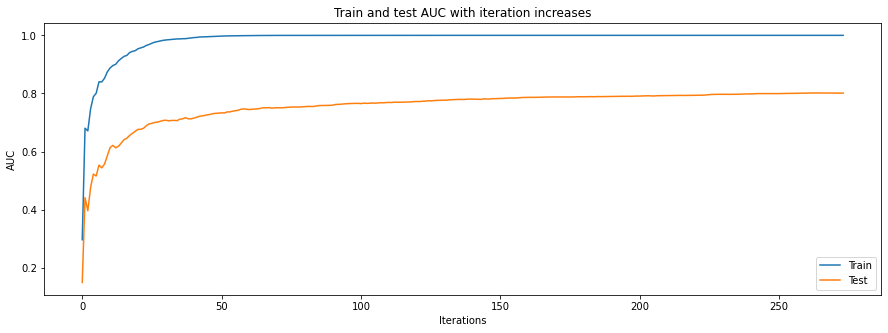

In [38]:
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(test_auc_tree, label='Test')

plt.title("Train and test AUC with iteration increases")
plt.xlabel("Iterations")
plt.ylabel("AUC")
plt.legend(loc='lower right')
plt.show()

In [39]:
cutoff_df = pd.DataFrame({'Actual':y_test.tolist(),'Predicted':list(xgb_clf.predict(X_test)),
                          'class_0' :list(xgb_clf.predict_proba(X_test)[:,0]),
                          'class_1' :list(xgb_clf.predict_proba(X_test)[:,1])})

In [40]:
cutoff_df.head()

,Actual,Predicted,class_0,class_1
0,0,0,0.999959,0.000041
1,0,0,0.999103,0.000897
2,0,0,0.999959,0.000041
3,0,0,0.999856,0.000144
4,0,0,0.998829,0.001171


In [41]:
cutoff_df[0:1]

,Actual,Predicted,class_0,class_1
0,0,0,0.999959,0.000041


In [42]:
def threshold_test(y,perc):
    if y >= perc:
        x = 1
    else:
        x= 0
    return x

In [43]:
precision_list = []
recall_list = []
accuracy_list = []
f1_score_list = []
threshold_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
for i in range(len(threshold_list)):
    thresh_preds = []
    for j in range(len(cutoff_df)):
        thresh_preds.append(threshold_test(cutoff_df[j:j+1]['class_1'].values[0],threshold_list[i]))
    recall_list.append(mt.recall_score(y_test,thresh_preds))
    precision_list.append(mt.precision_score(y_test,thresh_preds)) 
    accuracy_list.append(accuracy_score(y_test,thresh_preds))
    f1_score_list.append(f1_score(y_test,thresh_preds))

In [44]:
cutoff_results_df = pd.DataFrame({'Threshold':threshold_list,'Accuracy':accuracy_list,'Precision' :precision_list,
                                  'Recall' :recall_list,'F1_Score':f1_score_list})

In [45]:
cutoff_results_df.head()

,Threshold,Accuracy,Precision,Recall,F1_Score
0,0.1,0.967976,0.641129,0.760766,0.695842
1,0.2,0.973736,0.744845,0.691388,0.717122
2,0.3,0.976616,0.817109,0.662679,0.731836
3,0.4,0.976500,0.838608,0.633971,0.722071
4,0.5,0.976500,0.856667,0.614833,0.715877


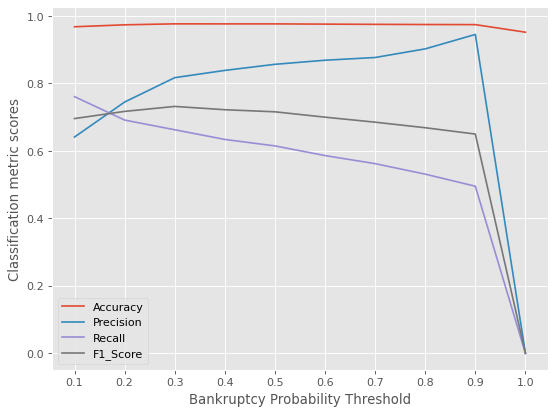

In [46]:
figure(figsize=(8, 6), dpi=80)
plt.style.use('ggplot')
plt.plot(cutoff_results_df['Accuracy'], label='Accuracy')
plt.plot(cutoff_results_df['Precision'], label='Precision')
plt.plot(cutoff_results_df['Recall'], label='Recall')
plt.plot(cutoff_results_df['F1_Score'], label='F1_Score')
plt.xticks(list(range(cutoff_results_df.shape[0])), cutoff_results_df['Threshold'])
plt.xlabel('Bankruptcy Probability Threshold')
plt.ylabel('Classification metric scores')
plt.legend()
plt.show()

In [47]:
weights = xgb_clf.feature_importances_.ravel()
feature_names = X.columns.values                  
ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

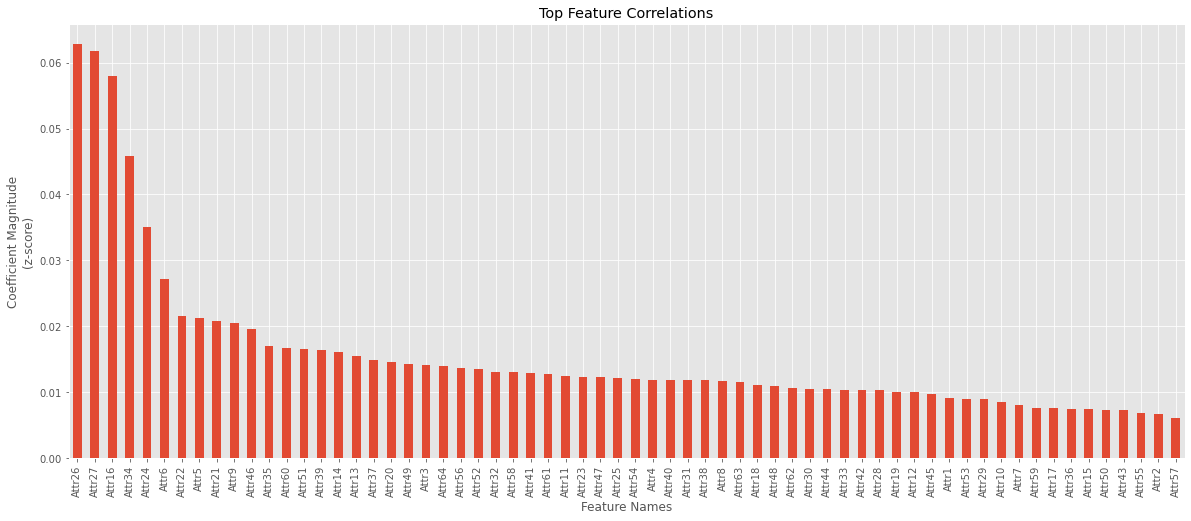

In [48]:
wt_plt_df = ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data